# Correlations
Here we present the study of the relationships between the key features we've 
picked out.

#### Environment Setup

In [110]:
## external
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from scipy.stats import linregress

## stdlib
from itertools import product
from pathlib import Path
from typing import Any, Callable
from pprint import pprint

#### Data Loading & Setup

In [111]:
# load dfs
# load in datasets
home_dir = Path().cwd().parent / "cleaned-datasets"

## financial data
economic_df = pd.read_csv(
    home_dir / "interpolated_economic_data.csv", engine="c", low_memory=False
)

## meat data
meat_storage_df = pd.read_csv(
    home_dir / "Cleaned_Meat_Stats_Cold_Storage.csv", engine="c",
    low_memory=False
)
meat_production_df = pd.read_csv(
    home_dir / "Cleaned_Meat_Stats_Meat_Production.csv", engine="c",
    low_memory=False
)
meat_slaughter_counts_df = pd.read_csv(
    home_dir / "Cleaned_Meat_Stats_Slaughter_Counts.csv", engine="c",
    low_memory=False
)

# generate lookup for easy replication downstream
dfs = {
    "economic": economic_df,
    "meat_storage": meat_storage_df,
    "meat_production": meat_production_df,
    "meat_slaughter_counts": meat_slaughter_counts_df
}

## Generate Correlations & Regressions

#### Combined Dataframe

In [112]:
# setup combined dataframe
data = pd.DataFrame({
    "date": pd.date_range("2010-01-01", "2022-12-01", freq="MS")
})

## meat storage, production, count
subset_dfs = ["meat_storage", "meat_production", "meat_slaughter_counts"]
fields = ["Weight", "Production", "Count"]

for df, field in zip(subset_dfs, fields):
    ### grab data
    meat_groups = dfs[df]
    
    ### ensure dtypes
    meat_groups["Date"] = pd.to_datetime(meat_groups["Date"])
    meat_groups[field] = meat_groups[field].astype(float)
    meat_groups.rename(columns={"Date": "date"}, inplace=True)
    
    ### split by meat type
    red_meat = meat_groups[
        meat_groups["Type_Of_Meat"] == "Red Meat"
    ][["date", field]].sort_values(by="date")
    
    poultry_meat = meat_groups[
        meat_groups["Type_Of_Meat"] == "Poultry"
    ][["date", field]].sort_values(by="date")
    
    ### rename
    red_meat.rename(columns={field: f"Red_Meat_{field}"}, inplace=True)
    poultry_meat.rename(columns={field: f"Poultry_Meat_{field}"}, inplace=True)
    
    ### add to combined dataframe
    data = data.merge(
        red_meat,
        on="date"
    )
    data = data.merge(
        poultry_meat,
        on="date"
    )

## unemployment rates
### aggregate rates into a single rate across the whole country; note, we'll 
### conduct a weighted averaging to ensure a more accurate representation
state_pop = pd.read_csv(
    home_dir / "state_populations.csv"
)

### convert to proportions
state_pop["population"] = state_pop["population"] / state_pop["population"].sum()

### create weighted unemployment rate
df = dfs["economic"]
df = df.merge(state_pop, on="state")

df["unemployment_rate"] = df["unemployment_rate"] * df["population"]
weighted_unemployment_rates = df.groupby("date")["unemployment_rate"].sum().reset_index()

### sort by date
weighted_unemployment_rates["date"] = pd.to_datetime(weighted_unemployment_rates["date"])
weighted_unemployment_rates.sort_index(inplace=True)

### add to dataframe
data = data.merge(
    weighted_unemployment_rates,
    on="date"
)

## inspect
print(data.head())

## export
data.to_csv(home_dir / "compiled_df.csv", index=False)

        date  Red_Meat_Weight  Poultry_Meat_Weight  Red_Meat_Production  \
0 2010-01-01           924.89               903.62               7788.3   
1 2010-02-01           938.38               940.04               7430.4   
2 2010-03-01           941.92               976.64               8515.9   
3 2010-04-01           921.76               999.04               7982.1   
4 2010-05-01           876.28              1053.68               7422.2   

   Poultry_Meat_Production  Red_Meat_Count  Poultry_Meat_Count  \
0                   3325.3         47097.5            701418.0   
1                   3198.4         45558.7            679766.0   
2                   3630.8         52691.2            782464.0   
3                   3569.0         48233.2            745902.0   
4                   3515.3         43611.4            735859.0   

   unemployment_rate  
0           7.198415  
1           7.269579  
2           7.341324  
3           7.413657  
4           7.486586  


#### Correlational Study

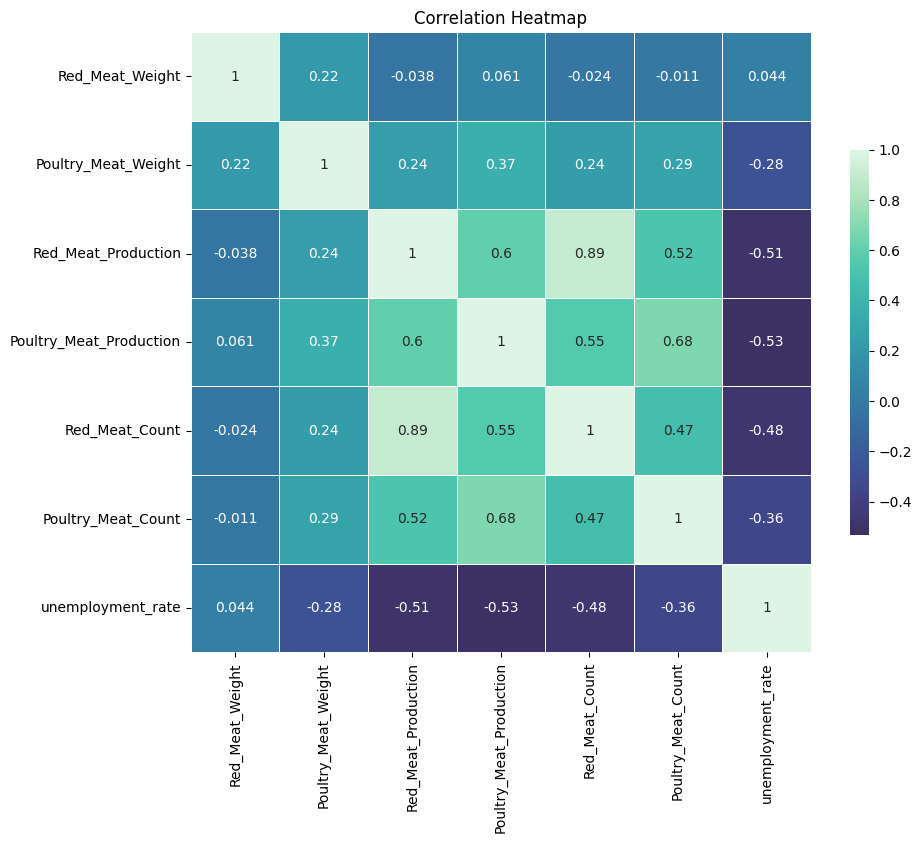

In [113]:
## correlation plot
### kendall for non-linearity
corr_matrix = data.drop(columns="date").corr(method="kendall")

### plotting
plt.figure(figsize=(10, 10))
sns.heatmap(
    corr_matrix, annot=True, cmap="mako", center=0, square=True,
    linewidths=.5, cbar_kws={"shrink": .5}
)

# Customize the plot
plt.title("Correlation Heatmap")
plt.savefig(
    Path().cwd().parent / "visualizations" / "Correlation Heatmap", dpi=400
)
plt.show()

#### Scatter & Regression Study

(Weight, Production): 0.15489336994309433


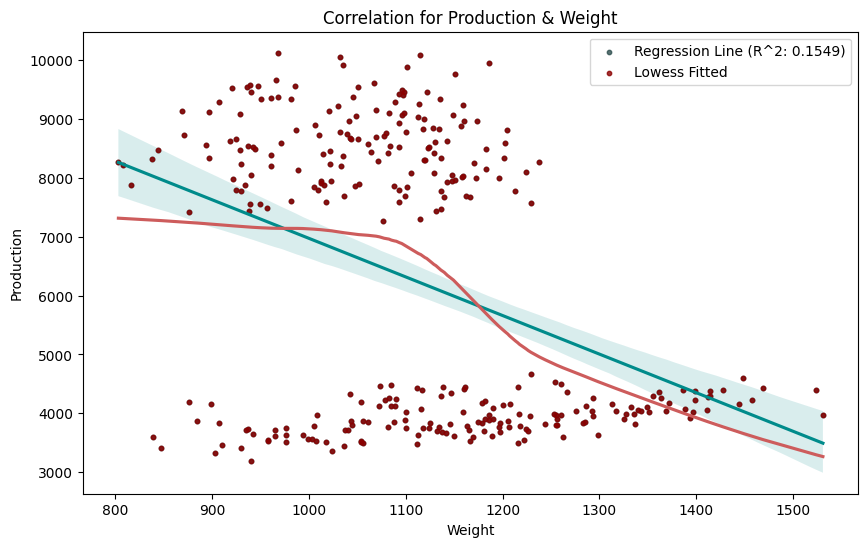

(Weight, Count): 0.21606462728838574


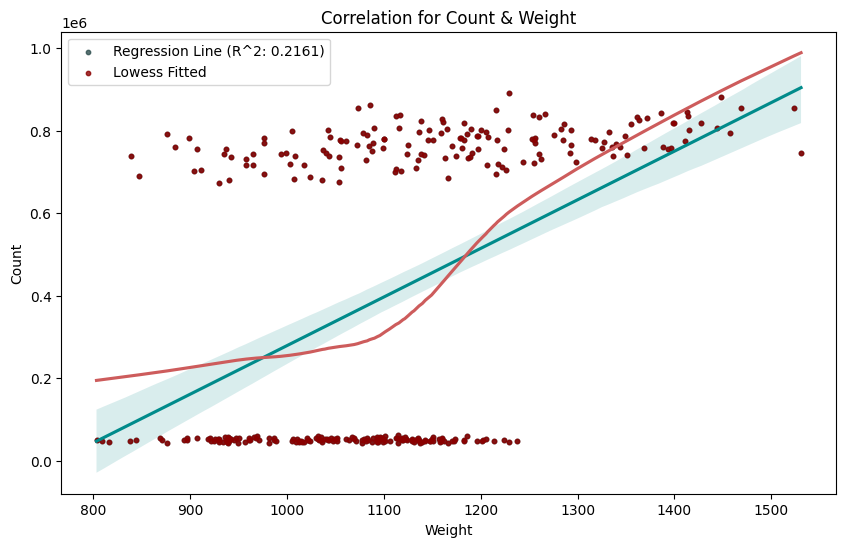

(Weight, unemployment_rate): nan


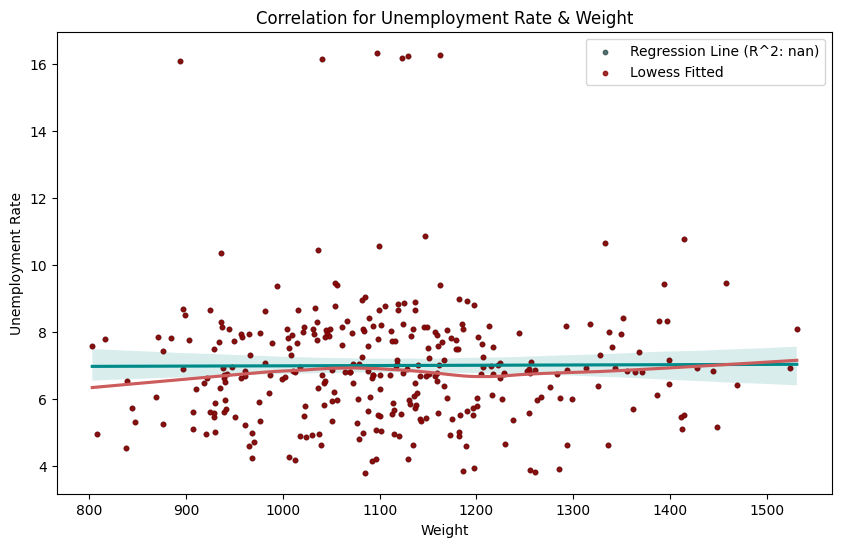

(Production, Count): 0.9263213539985361


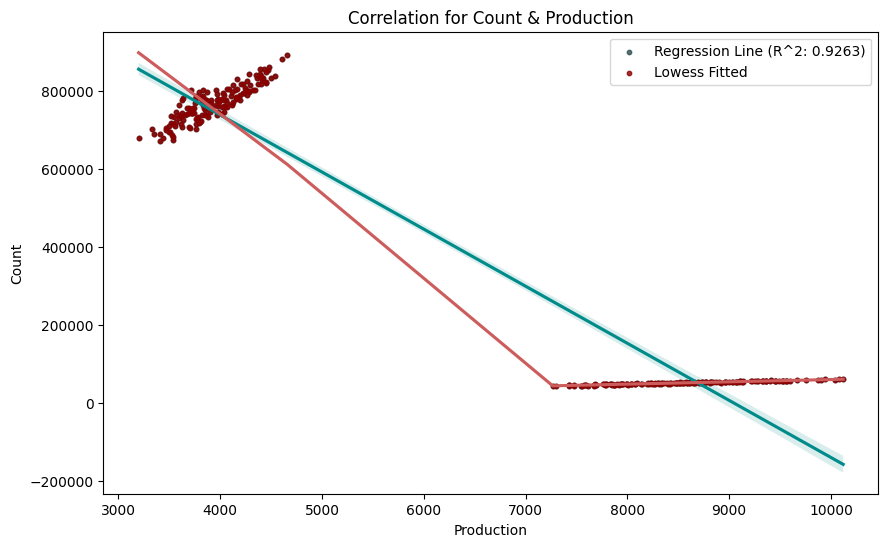

(Production, unemployment_rate): nan


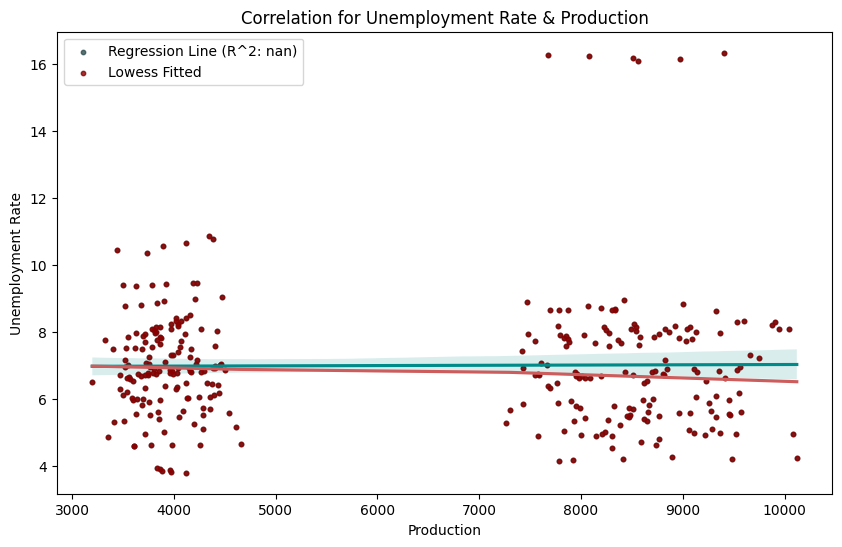

(Count, unemployment_rate): nan


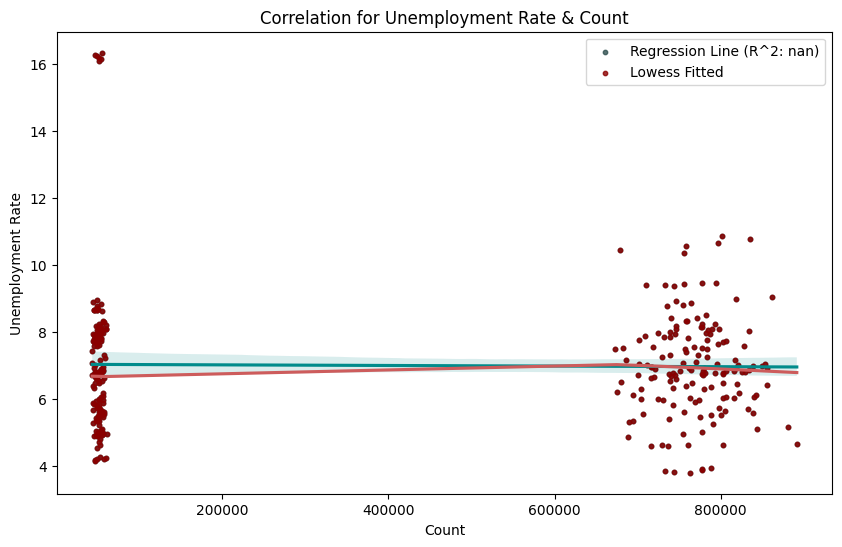

In [117]:
## setup traversal
subset_dfs = ["meat_storage", "meat_production", "meat_slaughter_counts", "economic"]
fields = ["Weight", "Production", "Count", "unemployment_rate"]

## for each combo, scatter, regression, and measure fit
for i in range(len(subset_dfs)):
    ### grab df
    df_x = dfs[subset_dfs[i]]
    
    ### for each possible second df
    for j in range(i + 1, len(dfs)):
        ### grab df
        df_y = dfs[subset_dfs[j]]
        
        ### make sole df
        plot_df = pd.DataFrame({
            "x": df_x[fields[i]],
            "y": df_y[fields[j]]
        })
        
        ### plotting
        plt.figure(figsize=(10, 6))
        
        ### calculate the regression and R^2 coefficient
        slope, intercept, r_value, p_value, std_err = linregress(
            plot_df["x"], plot_df["y"]
        )
        r_squared = r_value**2
        
        sns.regplot(
            x="x", y="y", data=plot_df,
            scatter_kws={"s": 10, "color": "darkslategrey", "marker": "D"},
            line_kws={"color": "darkcyan"}, lowess=False,
            label=f"Regression Line (R^2: {r_squared:.4f})"
        )
        sns.regplot(
            x="x", y="y", data=plot_df,
            scatter_kws={"s": 10, "color": "darkred", "marker": None},
            line_kws={"color": "indianred"}, lowess=True, label="Lowess Fitted"
        )
        plt.title(f"Correlation for {fields[j].replace('_', ' ').title()} & {fields[i].replace('_', ' ').title()}")
        plt.xlabel(f"{fields[i].replace('_', ' ').title()}")
        plt.ylabel(f"{fields[j].replace('_', ' ').title()}")
        plt.legend()
        
        ### report
        print(f"({fields[i]}, {fields[j]}): {r_squared}")
        plt.savefig(Path().cwd().parent / "visualizations" / f"Correlation for {fields[j]} & {fields[i]}")
        plt.show()